# Building Amazon-Style Review Highlights

**Goal:** Build a feature that automatically extracts aspects (like "Battery Life", "Camera Quality") from product reviews and shows sentiment breakdown.

**What We'll Learn:**
1. Text Preprocessing (Tokenization, Lemmatization, POS Tagging)
2. N-gram Analysis (Bigrams)
3. Word Embeddings (Word2Vec)
4. Clustering for Aspect Discovery

**Dataset:** Cell phone reviews from Amazon

## 1. Load the Data

In [1]:
import pandas as pd

df = pd.read_csv("20191226-reviews.csv")
print(f"Total reviews: {len(df):,}")
df.head()

Total reviews: 67,986


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


<Axes: title={'center': 'Rating Distribution'}, xlabel='rating'>

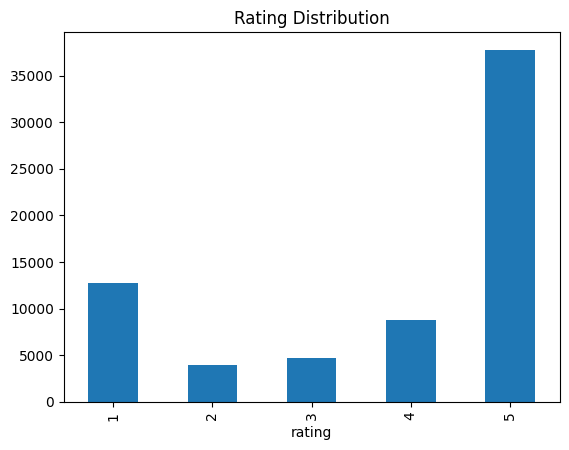

In [2]:
# Quick look at ratings distribution
df['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution')

In [3]:
# Sample review text
print(df['body'].iloc[0])

I had the Samsung A600 for awhile which is absolute doo doo. You can read my review on it and detect my rage at the stupid thing. It finally died on me so I used this Nokia phone I bought in a garage sale for $1. I wonder y she sold it so cheap?... Bad: ===> I hate the menu. It takes forever to get to what you want because you have to scroll endlessly. Usually phones have numbered categories so u can simply press the # and get where you want to go. ===> It's a pain to put it on silent or vibrate. If you're in class and it rings, you have to turn it off immediately. There's no fast way to silence the damn thing. Always remember to put it on silent! I learned that the hard way. ===> It's so true about the case. It's a mission to get off and will break ur nails in the process. Also, you'll damage the case each time u try. For some reason the phone started giving me problems once I did succeed in opening it. ===> Buttons could be a bit bigger. Vibration could be stronger. Good: ===> Recept

## 2. Text Preprocessing

Before we can analyze reviews, we need to clean and normalize the text. We'll use NLTK (Natural Language Toolkit).

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Tokenization

**What:** Splitting text into individual words (tokens).

```
"The battery life is great!" → ["The", "battery", "life", "is", "great", "!"]
```

**Why:** We need to work with individual words to count them, find patterns, etc.

In [5]:
from nltk.tokenize import word_tokenize

sample = "The battery life is great!"
tokens = word_tokenize(sample)
print(tokens)

['The', 'battery', 'life', 'is', 'great', '!']


### Stopwords

**What:** Common words that don't carry much meaning: "the", "is", "a", "and", etc.

**Why:** Removing them helps us focus on the important words.

In [6]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
print(f"Total stopwords: {len(stop_words)}")
print(f"Examples: {list(stop_words)[:10]}")

# Filter out stopwords
filtered = [w for w in tokens if w.lower() not in stop_words]
print(f"\nBefore: {tokens}")
print(f"After:  {filtered}")

Total stopwords: 198
Examples: ['before', 'his', "it'll", 'them', 've', 'couldn', 'again', 'does', 'shan', 'those']

Before: ['The', 'battery', 'life', 'is', 'great', '!']
After:  ['battery', 'life', 'great', '!']


### Lemmatization

**What:** Converting words to their base/dictionary form.

```
"batteries" → "battery"
"running"   → "run"  
"better"    → "good"
```

**Why:** We want "battery" and "batteries" to be counted as the same word.

**Lemmatization vs Stemming:**
- **Stemming:** Chops off endings (fast but crude): "studies" → "studi"
- **Lemmatization:** Uses vocabulary (slower but accurate): "studies" → "study"

In [7]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

words = ["batteries", "running", "phones", "better"]
for word in words:
    print(f"{word:12} → {lemmatizer.lemmatize(word)}")

batteries    → battery
running      → running
phones       → phone
better       → better


### Part-of-Speech (POS) Tagging

**What:** Identifying the grammatical role of each word (noun, verb, adjective, etc.)

**Common POS Tags:**
| Tag | Meaning | Example |
|-----|---------|---------|
| NN  | Noun (singular) | battery, phone |
| NNS | Noun (plural) | batteries, phones |
| VB  | Verb (base) | run, charge |
| JJ  | Adjective | great, terrible |
| RB  | Adverb | quickly, very |

**Why it matters for us:** Product features are usually **NOUNS** (battery, screen, camera). By filtering for nouns, we can automatically find what people are talking about!

In [8]:
# POS Tagging example
sentence = "The battery life is amazing but the camera quality is terrible"
tokens = word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)

print("Word → POS Tag")
print("-" * 20)
for word, tag in tagged:
    print(f"{word:12} → {tag}")

Word → POS Tag
--------------------
The          → DT
battery      → NN
life         → NN
is           → VBZ
amazing      → VBG
but          → CC
the          → DT
camera       → NN
quality      → NN
is           → VBZ
terrible     → JJ


In [9]:
# Extract only nouns
NOUN_TAGS = {'NN', 'NNS'}  # Singular and plural nouns
nouns = [word for word, tag in tagged if tag in NOUN_TAGS]
print(f"Nouns found: {nouns}")

Nouns found: ['battery', 'life', 'camera', 'quality']


### Putting It All Together

Now let's create a function that extracts nouns from review text:

In [10]:
def extract_nouns(text):
    """Extract nouns from text: tokenize → POS tag → filter nouns → lemmatize"""
    if not isinstance(text, str):
        return []
    
    tokens = word_tokenize(text.lower())
    tagged = nltk.pos_tag(tokens)
    
    nouns = [
        lemmatizer.lemmatize(word) 
        for word, tag in tagged 
        if tag in NOUN_TAGS and word.isalpha() and word not in stop_words and len(word) > 2
    ]
    return nouns

# Test it
test_review = "The battery life is amazing and the camera takes great photos"
print(f"Input: {test_review}")
print(f"Nouns: {extract_nouns(test_review)}")

Input: The battery life is amazing and the camera takes great photos
Nouns: ['battery', 'life', 'camera', 'photo']


In [11]:
# Apply to all reviews (this takes ~1 minute)
df = df.dropna(subset=['body'])
df['nouns'] = df['body'].apply(extract_nouns)
df[['body', 'nouns']].head()

,body,nouns
0,I had the Samsung A600 for awhile which is abs...,"[samsung, awhile, doo, doo, review, rage, thin..."
1,Due to a software issue between Nokia and Spri...,"[software, issue, sprint, phone, text, messagi..."
2,"This is a great, reliable phone. I also purcha...","[phone, phone, samsung, menu, speed, dialing, ..."
3,"I love the phone and all, because I really did...","[phone, price, bill, phone, month, accessory, ..."
4,The phone has been great for every purpose it ...,"[phone, purpose, day, couldnt, case, case, pic..."


## 3. Feature Extraction: Bigrams

**Problem:** Single words miss important context.
- "battery" could be positive ("great battery") or negative ("battery died")
- "battery life" is more specific and meaningful

**Solution:** Extract **bigrams** (pairs of consecutive words)

In [12]:
from nltk import ngrams
from collections import Counter

# Simple tokenizer for bigrams (just lowercase + split)
def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    return [w for w in text.lower().split() if w.isalpha() and w not in stop_words]

# Example of bigrams
sample = "the battery life is great"
tokens = simple_tokenize(sample)
bigrams = list(ngrams(tokens, 2))
print(f"Tokens:  {tokens}")
print(f"Bigrams: {bigrams}")

Tokens:  ['battery', 'life', 'great']
Bigrams: [('battery', 'life'), ('life', 'great')]


In [13]:
# Extract bigrams from all reviews
def get_bigrams(text):
    tokens = simple_tokenize(text)
    return [f"{a}_{b}" for a, b in ngrams(tokens, 2)]

df['bigrams'] = df['body'].apply(get_bigrams)
df[['body', 'bigrams']].head()

,body,bigrams
0,I had the Samsung A600 for awhile which is abs...,"[samsung_awhile, awhile_absolute, absolute_doo..."
1,Due to a software issue between Nokia and Spri...,"[due_software, software_issue, issue_nokia, no..."
2,"This is a great, reliable phone. I also purcha...","[reliable_also, also_purchased, purchased_phon..."
3,"I love the phone and all, because I really did...","[love_phone, phone_really, really_need, need_e..."
4,The phone has been great for every purpose it ...,"[phone_great, great_every, every_purpose, purp..."


In [14]:
# Find most common bigrams
all_bigrams = [bg for bigrams in df['bigrams'] for bg in bigrams]
bigram_counts = Counter(all_bigrams)

print("Top 15 Bigrams:")
for bg, count in bigram_counts.most_common(15):
    print(f"  {bg.replace('_', ' '):20} {count:,}")

Top 15 Bigrams:
  battery life         4,203
  great phone          2,338
  sim card             2,274
  phone works          1,401
  bought phone         1,365
  brand new            1,294
  new phone            1,262
  good phone           1,239
  phone great          1,212
  best phone           1,148
  samsung galaxy       1,067
  works great          1,024
  phone came           978
  phone ever           972
  use phone            949


In [15]:
# Combine nouns + top bigrams as "features"
# Keep only bigrams that appear frequently enough
MIN_COUNT = 50
top_bigrams = {bg for bg, c in bigram_counts.items() if c >= MIN_COUNT}
print(f"Keeping {len(top_bigrams)} bigrams with >= {MIN_COUNT} occurrences")

def get_features(row):
    """Combine nouns + filtered bigrams"""
    features = list(row['nouns'])
    features += [bg for bg in row['bigrams'] if bg in top_bigrams]
    return features

df['features'] = df.apply(get_features, axis=1)
df[['body', 'features']].head()

Keeping 1759 bigrams with >= 50 occurrences


,body,features
0,I had the Samsung A600 for awhile which is abs...,"[samsung, awhile, doo, doo, review, rage, thin..."
1,Due to a software issue between Nokia and Spri...,"[software, issue, sprint, phone, text, messagi..."
2,"This is a great, reliable phone. I also purcha...","[phone, phone, samsung, menu, speed, dialing, ..."
3,"I love the phone and all, because I really did...","[phone, price, bill, phone, month, accessory, ..."
4,The phone has been great for every purpose it ...,"[phone, purpose, day, couldnt, case, case, pic..."


## 4. Sentiment Analysis

**Simple approach:** Use the star rating as a proxy for sentiment.
- Rating > 3 → Positive
- Rating <= 3 → Negative

We want to know: For each feature (like "battery life"), how many positive vs negative mentions?

In [16]:
# Add sentiment label
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')
df['sentiment'].value_counts()

sentiment
positive    46558
negative    21402
Name: count, dtype: int64

### Pandas Magic: `explode` + `groupby`

Instead of writing loops to count features by sentiment, we can use Pandas!

In [26]:
# explode() turns lists into rows
# Example: one row with features=['phone', 'battery'] becomes two rows
df_exploded = df[['features', 'sentiment']].explode('features')
df_exploded = df_exploded[df_exploded['features'].notna()]  # Remove empty
df_exploded.tail(10)

,features,sentiment
67985,style,positive
67985,phone,positive
67985,size,positive
67985,phone,positive
67985,feature,positive
67985,phone,positive
67985,love_size,positive
67985,size_phone,positive
67985,phone_many,positive
67985,great_good,positive


In [18]:
# Count by feature + sentiment
feature_sentiment = df_exploded.groupby(['features', 'sentiment']).size().unstack(fill_value=0)
feature_sentiment['total'] = feature_sentiment['positive'] + feature_sentiment['negative']
feature_sentiment = feature_sentiment.sort_values('total', ascending=False)
feature_sentiment.head(20)

sentiment,negative,positive,total
features,,,
phone,40424,65198,105622
battery,5265,9782,15047
screen,5508,8357,13865
camera,2661,8440,11101
time,4335,5468,9803
day,3374,5385,8759
price,1161,6185,7346
issue,3237,3541,6778
life,1693,5031,6724


### Bigram Probabilities: How Word Associations Differ by Sentiment

Beyond just counting features, we can analyze **conditional probabilities** - given a word, what word is likely to follow?

**The Bigram Probability Formula:**

$$P(w_2 | w_1) = \frac{\text{count}(w_1, w_2)}{\sum_{w'} \text{count}(w_1, w')}$$

This reads as: "The probability of word $w_2$ given that we just saw word $w_1$"

**Why this matters:**
- In **positive** reviews: "battery" → "life", "backup" (good associations)
- In **negative** reviews: "battery" → "drain", "issue" (bad associations)

The same feature word leads to different follow-up words depending on sentiment!

In [ ]:
# Calculate bigram counts by sentiment
pos_reviews = df[df['sentiment'] == 'positive']['body']
neg_reviews = df[df['sentiment'] == 'negative']['body']

def get_bigram_counts(texts):
    """Count all bigrams in a collection of texts"""
    counts = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        counts.update(ngrams(tokens, 2))
    return counts

pos_bigrams = get_bigram_counts(pos_reviews)
neg_bigrams = get_bigram_counts(neg_reviews)

print(f"Unique bigrams in positive reviews: {len(pos_bigrams):,}")
print(f"Unique bigrams in negative reviews: {len(neg_bigrams):,}")

In [ ]:
def get_conditional_probs(bigram_counts, word1):
    """
    Calculate P(w2 | w1) for all words that follow word1
    Returns dict: {word2: probability}
    """
    # Get all bigrams starting with word1
    following = {bg[1]: count for bg, count in bigram_counts.items() if bg[0] == word1}
    
    # Calculate total count (denominator)
    total = sum(following.values())
    
    if total == 0:
        return {}
    
    # Calculate probabilities
    return {w2: count / total for w2, count in following.items()}

# Example: What follows "battery" in positive vs negative reviews?
word = "battery"

pos_probs = get_conditional_probs(pos_bigrams, word)
neg_probs = get_conditional_probs(neg_bigrams, word)

print(f"P(word | '{word}') - Top 5 in each sentiment:\n")
print("POSITIVE reviews:")
for w2, prob in sorted(pos_probs.items(), key=lambda x: -x[1])[:5]:
    print(f"  P('{w2}' | '{word}') = {prob:.3f}")

print("\nNEGATIVE reviews:")
for w2, prob in sorted(neg_probs.items(), key=lambda x: -x[1])[:5]:
    print(f"  P('{w2}' | '{word}') = {prob:.3f}")

In [ ]:
# Compare multiple feature words
feature_words = ['screen', 'camera', 'price', 'phone']

print("=" * 60)
print("BIGRAM PROBABILITY COMPARISON BY SENTIMENT")
print("=" * 60)

for word in feature_words:
    pos_probs = get_conditional_probs(pos_bigrams, word)
    neg_probs = get_conditional_probs(neg_bigrams, word)
    
    if pos_probs or neg_probs:
        print(f"\n'{word}' is followed by:")
        
        # Top positive association
        if pos_probs:
            top_pos = max(pos_probs.items(), key=lambda x: x[1])
            print(f"  + Positive: '{top_pos[0]}' (P={top_pos[1]:.2f})")
        
        # Top negative association  
        if neg_probs:
            top_neg = max(neg_probs.items(), key=lambda x: x[1])
            print(f"  - Negative: '{top_neg[0]}' (P={top_neg[1]:.2f})")

**Takeaway:** Bigram probabilities reveal sentiment-specific language patterns. This is powerful because:
1. We can **detect sentiment** from word associations (without needing explicit sentiment words)
2. We can **understand why** a review is positive/negative (not just that it is)
3. This works **without labeled training data** - pure statistics!

## 5. Grouping Features: Word2Vec & Clustering

**Problem:** We have many related features:
- "screen", "display", "display_quality" → all about **Display**
- "battery", "battery_life", "charge" → all about **Battery**

**Solution:** Use **Word Embeddings** to find similar words, then **cluster** them.

### Word2Vec: Words as Vectors

**Idea:** Represent words as vectors (lists of numbers) where similar words have similar vectors.

```
"battery" → [0.2, 0.8, -0.3, ...]
"charge"  → [0.3, 0.7, -0.2, ...]  ← similar!
"screen"  → [-0.5, 0.1, 0.9, ...]  ← different!
```

**How it learns:** Words that appear in similar contexts get similar vectors.
- "The **battery** is great" / "The **charge** is great" → battery ≈ charge

In [19]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec on our review tokens
sentences = df['body'].apply(simple_tokenize).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
print(f"Vocabulary size: {len(model.wv)}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 9332


In [20]:
# Find similar words
print("Words similar to 'battery':")
for word, score in model.wv.most_similar('battery', topn=5):
    print(f"  {word}: {score:.3f}")

print("\nWords similar to 'screen':")
for word, score in model.wv.most_similar('screen', topn=5):
    print(f"  {word}: {score:.3f}")

Words similar to 'battery':
  batter: 0.792
  sucks: 0.616
  charges: 0.606
  batteries: 0.601
  recharge: 0.598

Words similar to 'screen':
  display: 0.722
  screens: 0.618
  edges: 0.551
  touchscreen: 0.548
  finish: 0.546


### Clustering: Grouping Similar Features

**K-Means Clustering:**
1. Pick K cluster centers randomly
2. Assign each point to nearest center
3. Move centers to mean of assigned points
4. Repeat until stable

In [21]:
from sklearn.cluster import KMeans

# Get vectors for top features
top_features = feature_sentiment.head(100).index.tolist()

def get_vector(feature):
    """Get vector for a feature (noun or bigram)"""
    if feature in model.wv:
        return model.wv[feature]
    elif '_' in feature:  # bigram
        parts = feature.split('_')
        if parts[0] in model.wv and parts[1] in model.wv:
            return (model.wv[parts[0]] + model.wv[parts[1]]) / 2
    return None

# Build feature matrix
feature_vectors = []
feature_names = []
for feat in top_features:
    vec = get_vector(feat)
    if vec is not None:
        feature_vectors.append(vec)
        feature_names.append(feat)

X = np.array(feature_vectors)
print(f"Clustering {len(feature_names)} features")

Clustering 100 features


In [22]:
# Run K-Means
NUM_CLUSTERS = 8
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Group features by cluster
cluster_features = {}
for feat, cluster_id in zip(feature_names, clusters):
    if cluster_id not in cluster_features:
        cluster_features[cluster_id] = []
    cluster_features[cluster_id].append(feat)

# Display clusters
print("DISCOVERED ASPECTS")
print("=" * 50)
for cluster_id, features in cluster_features.items():
    # Name cluster by most common feature
    label = features[0].replace('_', ' ').title()
    print(f"\n{label}:")
    print(f"  {', '.join(f.replace('_', ' ') for f in features[:6])}")

DISCOVERED ASPECTS

Phone:
  phone, issue, problem, thing, work, everything

Battery:
  battery, time, day, month, year, hour

Screen:
  screen, case, scratch, hand, edge, glass

Camera:
  camera, price, life, quality, iphone, note

Samsung:
  samsung, device, product, review, condition, seller

Card:
  card, verizon, service, sim, sim card, network

Apps:
  apps, feature, picture, google, app, button

Charger:
  charger, charge


## 6. Final Visualization: Amazon-Style Review Highlights

Let's aggregate sentiment by aspect cluster and visualize!

In [23]:
import matplotlib.pyplot as plt

# Aggregate sentiment by cluster
aspect_data = []
for cluster_id, features in cluster_features.items():
    label = features[0].replace('_', ' ').title()
    
    # Sum sentiment across all features in cluster
    pos_total = 0
    neg_total = 0
    for feat in features:
        if feat in feature_sentiment.index:
            pos_total += feature_sentiment.loc[feat, 'positive']
            neg_total += feature_sentiment.loc[feat, 'negative']
    
    if pos_total + neg_total > 0:
        aspect_data.append({
            'aspect': label,
            'positive': pos_total,
            'negative': neg_total,
            'total': pos_total + neg_total,
            'terms': features[:4]
        })

# Sort by total mentions
aspect_data = sorted(aspect_data, key=lambda x: x['total'], reverse=True)

In [24]:
# Amazon-style text summary
print("=" * 60)
print("REVIEW HIGHLIGHTS")
print("=" * 60)

for asp in aspect_data:
    pct = asp['positive'] / asp['total'] * 100
    bar = "█" * int(pct / 5) + "░" * (20 - int(pct / 5))
    print(f"\n{asp['aspect']} ({asp['total']:,} mentions)")
    print(f"  {bar} {asp['positive']:,} positive, {asp['negative']:,} negative")
    print(f"  Related: {', '.join(t.replace('_', ' ') for t in asp['terms'])}")

REVIEW HIGHLIGHTS

Phone (168,949 mentions)
  ████████████░░░░░░░░ 103,437 positive, 65,512 negative
  Related: phone, issue, problem, thing

Camera (71,398 mentions)
  ███████████████░░░░░ 53,994 positive, 17,404 negative
  Related: camera, price, life, quality

Samsung (54,063 mentions)
  ███████████░░░░░░░░░ 32,096 positive, 21,967 negative
  Related: samsung, device, product, review

Battery (49,177 mentions)
  ███████████░░░░░░░░░ 28,235 positive, 20,942 negative
  Related: battery, time, day, month

Apps (42,787 mentions)
  █████████████░░░░░░░ 29,593 positive, 13,194 negative
  Related: apps, feature, picture, google

Card (26,238 mentions)
  ███████████░░░░░░░░░ 15,105 positive, 11,133 negative
  Related: card, verizon, service, sim

Screen (25,737 mentions)
  ████████████░░░░░░░░ 16,656 positive, 9,081 negative
  Related: screen, case, scratch, hand

Charger (6,565 mentions)
  ███████████░░░░░░░░░ 3,814 positive, 2,751 negative
  Related: charger, charge


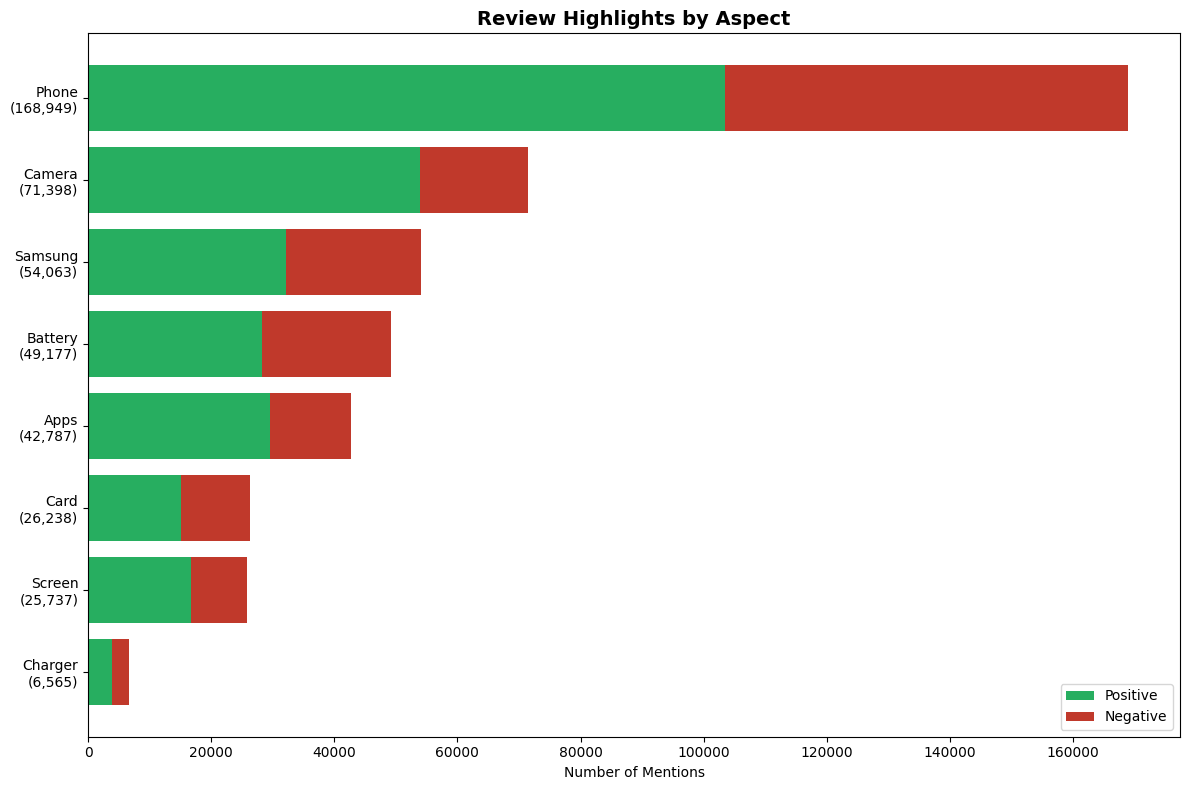

In [25]:
# Bar chart visualization
fig, ax = plt.subplots(figsize=(12, 8))

aspects = [a['aspect'] for a in aspect_data]
positives = [a['positive'] for a in aspect_data]
negatives = [a['negative'] for a in aspect_data]

y = range(len(aspects))
ax.barh(y, positives, color='#27ae60', label='Positive')
ax.barh(y, negatives, left=positives, color='#c0392b', label='Negative')

ax.set_yticks(y)
ax.set_yticklabels([f"{a['aspect']}\n({a['total']:,})" for a in aspect_data])
ax.set_xlabel('Number of Mentions')
ax.set_title('Review Highlights by Aspect', fontsize=14, fontweight='bold')
ax.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Summary

**What we built:** An unsupervised pipeline that extracts product aspects from reviews.

**NLP Techniques Used:**
1. **Tokenization** - Split text into words
2. **Stopword Removal** - Remove common words
3. **Lemmatization** - Normalize word forms
4. **POS Tagging** - Extract nouns (product features)
5. **Bigrams** - Capture multi-word features
6. **Word2Vec** - Learn semantic similarity
7. **K-Means Clustering** - Group related features

**Key Insight:** This pipeline works for ANY product - the aspects emerge automatically from the text!